In [ ]:
# 🌍 COFIEX Data Insights
### Análise dos Projetos e Financiamentos Internacionais do Setor Público Brasileiro

O objetivo deste notebook é analisar os projetos e programas do setor público brasileiro que contam com financiamento externo de organismos multilaterais e bilaterais, sob a coordenação da Comissão de Financiamentos Externos (COFIEX).

A análise combina:

Tratamento e exploração dos dados com Python (Pandas, Plotly)

Um painel interativo criado no Looker Studio, que resume os principais indicadores visuais.

## 📚 Sumário

1. Importação das bibliotecas e dados

2. Limpeza e tratamento dos dados

3. Análise exploratória

4. Visualizações interativas

5. Conclusões e próximos passos

## 📦 1. Importação das bibliotecas e carregamento dos dados
Aqui importamos as bibliotecas essenciais para análise e carregamos o arquivo Excel com os projetos COFIEX.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [28]:
# Importar as bibliotecas e seguir o notebook normalmente:

# Importação de bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import is_datetime64_any_dtype as is_datetime


# Configurações de exibição
pd.set_option('display.width', None)
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Configurações iniciais
pd.options.display.float_format = '{:,.2f}'.format
plt.style.use('default')

## 2. Carregamento e Exploração Inicial dos Dados

In [33]:
# Carregar os dados
df = pd.read_excel('/content/drive/MyDrive/Projeto EBAC FINAL/dados_2025-02-05.xlsx')


# %%
# Exploração inicial da estrutura dos dados
print("📋 DIMENSÕES DO DATASET:")
print(f"Linhas: {df.shape[0]:,}")
print(f"Colunas: {df.shape[1]}")
print("\n" + "="*50)

# %%
# Informações gerais sobre o dataset
df.info()

# Visualizar as primeiras entradas
print("PRIMEIRAS 5 ENTRADAS:")
df.head()

📋 DIMENSÕES DO DATASET:
Linhas: 2,977
Colunas: 26

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2977 entries, 0 to 2976
Data columns (total 26 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   cdCartaConsulta             2977 non-null   int64 
 1   nmProjeto                   2977 non-null   object
 2   sgProjeto                   2907 non-null   object
 3   nmSetor                     2891 non-null   object
 4   nmSujeito                   2977 non-null   object
 5   Regiao                      2977 non-null   object
 6   nmUnidadeFederal            2971 non-null   object
 7   nmAbrangenciaNacional       2977 non-null   object
 8   TipoFinanciamento           2977 non-null   object
 9   sgFonte                     2976 non-null   object
 10  VlDolar                     2977 non-null   object
 11  CpVlDolar                   2977 non-null   object
 12  sgMoeda                     2977 non-null   object
 1

,cdCartaConsulta,nmProjeto,sgProjeto,nmSetor,nmSujeito,Regiao,nmUnidadeFederal,nmAbrangenciaNacional,TipoFinanciamento,sgFonte,...,dtReuniaoNegociacao,dtAprovDiretoria,dtAprovacaoSenado,nuResolucaoSenado,dtAssinatura,nuoperacao,dtPrimeiraAmortizacao,dtUltimaAmortizacao,dtUltimoDesembolsoOriginal,dtUltimoDesembolsoVigente
0,60371,PROJETO ALFA/PROJECT ALFA,NaN,NaN,Instituto Internacional para Sustentabilidade...,Sudeste,Estado do Rio de Janeiro,Federal,Outros,Ch_Inst,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,60371,PROJETO ALFA/PROJECT ALFA,NaN,NaN,Instituto Internacional para Sustentabilidade...,Sudeste,Estado do Rio de Janeiro,Federal,Outros,Ch_Inst,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,12761,Programa de Desenvolvimento do Turismo Naciona...,PRODETUR NACIONAL GOIÂNIA,Comércio e Serviços (Turismo),aaa,Centro Oeste,Distrito Federal,Municipal,Operação de Crédito Externo,BID,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,59718,Apoio à Execução da Estratégia Nacional de Sim...,DOAÇÃO PRODEV ABDI,Fortalecimento Institucional,Agência Brasileira de Desenvolvimento Industri...,Nacional,Distrito Federal,Federal,Doações,BID/PRODEV,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,61246,Programa Novo Seguro de Crédito à Exportação (...,NSCE,Fortalecimento Institucional,Agência Brasileira Gestora de Fundos Garantido...,Nacional,Distrito Federal,Federal,Operação de Crédito Externo,BID,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Estatísticas descritivas das colunas numéricas

In [34]:
print("📊 ESTATÍSTICAS DESCRITIVAS:")
df.describe(include='all')

📊 ESTATÍSTICAS DESCRITIVAS:


,cdCartaConsulta,nmProjeto,sgProjeto,nmSetor,nmSujeito,Regiao,nmUnidadeFederal,nmAbrangenciaNacional,TipoFinanciamento,sgFonte,...,dtReuniaoNegociacao,dtAprovDiretoria,dtAprovacaoSenado,nuResolucaoSenado,dtAssinatura,nuoperacao,dtPrimeiraAmortizacao,dtUltimaAmortizacao,dtUltimoDesembolsoOriginal,dtUltimoDesembolsoVigente
count,"2,977.00",2977,2907,2891,2977,2977,2971,2977,2977,2976,...,904,1356,745,650,1370,1354,846,647,1193,1366
unique,NaN,2756,2714,29,407,6,27,3,6,110,...,816,1061,456,608,1077,1288,598,479,768,856
top,NaN,Projetos Demonstrativos Tipo A - PDA,PDA,Meio Ambiente,República Federativa do Brasil,Nacional,Distrito Federal,Estadual,Operação de Crédito Externo,BID,...,26/05/1995 00:00,17/12/1987 00:00,17/12/2009 00:00,25,20/07/1987 00:00,00,15/10/2015 00:00,15/10/2043 00:00,31/12/1999 00:00,31/12/1999 00:00
freq,NaN,7,7,508,734,1027,1055,1207,2205,810,...,5,7,11,5,7,30,8,5,14,17
mean,"58,854.97",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,"4,767.74",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,97.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,"58,433.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,"59,218.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,"60,044.00",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


 ## 3. Limpeza e Preparação dos Dados
  ### 3.1 Conversão de Datas


In [35]:
# Lista de colunas de data para conversão
cols_datas = [
    "dtRecebimento",
    "dtValidadeRecomendacao",
    "dtAprovDiretoria",
    "dtAssinatura",
    "dtUltimoDesembolsoOriginal",
    "dtUltimoDesembolsoVigente"
]

print("🔄 CONVERTENDO COLUNAS DE DATA...")

🔄 CONVERTENDO COLUNAS DE DATA...


In [36]:
# Converter para datetime e substituir datas inválidas por NaT
for col in cols_datas:
    df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)
    df[col] = df[col].replace(pd.Timestamp('1900-01-01'), pd.NaT)
    print(f"✅ {col}: {df[col].notna().sum()} datas válidas")

✅ dtRecebimento: 2977 datas válidas
✅ dtValidadeRecomendacao: 879 datas válidas
✅ dtAprovDiretoria: 1356 datas válidas
✅ dtAssinatura: 1370 datas válidas
✅ dtUltimoDesembolsoOriginal: 1192 datas válidas
✅ dtUltimoDesembolsoVigente: 1366 datas válidas


### 3.2 Remoção de Colunas Desnecessárias

In [37]:
# Colunas a serem removidas (baseado na análise de relevância)
colunas_para_dropar = [
    "dtReuniaoNegociacao",
    "dtAprovacaoSenado",
    "dtPrimeiraAmortizacao",
    "dtUltimaAmortizacao"
]

print(f"🗑️ REMOVENDO {len(colunas_para_dropar)} COLUNAS...")
df = df.drop(columns=colunas_para_dropar)
print(f"✅ Colunas restantes: {df.shape[1]}")

🗑️ REMOVENDO 4 COLUNAS...
✅ Colunas restantes: 22


### 3.3 Criação de Flags e Métricas

In [38]:
# Flags baseadas em datas
print("🏷️ CRIANDO FLAGS TEMPORAIS...")

# Criando métrica de eficiência administrativa: dias até assinatura
df['dias_ate_assinatura'] = (df['dtAssinatura'] - df['dtRecebimento']).dt.days
df['dias_ate_ultimo_desembolso'] = (df['dtUltimoDesembolsoVigente'] - df['dtRecebimento']).dt.days
df['projeto_assinado'] = df['dtAssinatura'].notnull()
df['projeto_desembolsado'] = df['dtUltimoDesembolsoVigente'].notnull()
df['dias_entre_assinatura_e_desembolso'] = (df['dtUltimoDesembolsoVigente'] - df['dtAssinatura']).dt.days

print(f"✅ Projetos assinados: {df['projeto_assinado'].sum():,}")
print(f"✅ Projetos desembolsados: {df['projeto_desembolsado'].sum():,}")

🏷️ CRIANDO FLAGS TEMPORAIS...
✅ Projetos assinados: 1,370
✅ Projetos desembolsados: 1,366


In [39]:
# Flag para projetos duplicados (baseado em cdCartaConsulta)
df['projeto_multifonte'] = df.duplicated(subset=['cdCartaConsulta'], keep=False)

### 3.4 Análise de Multi-fontes

In [40]:
print("🔍 ANALISANDO PROJETOS COM MÚLTIPLAS FONTES...")

# Contar quantidade de fontes diferentes por projeto
fontes_por_projeto = df.groupby('cdCartaConsulta')['sgFonte'].nunique().reset_index()
fontes_por_projeto.rename(columns={'sgFonte': 'qtd_fontes'}, inplace=True)
fontes_por_projeto['projeto_multi_fonte'] = fontes_por_projeto['qtd_fontes'] > 1

# Merge com dataframe original
df = df.merge(fontes_por_projeto[['cdCartaConsulta', 'projeto_multi_fonte']],
              on='cdCartaConsulta', how='left')

# Renomear coluna antiga para clarificar
df.rename(columns={'projeto_multifonte': 'projeto_duplicado'}, inplace=True)

print(f"📊 Projetos com múltiplas fontes: {df['projeto_multi_fonte'].sum():,}")

🔍 ANALISANDO PROJETOS COM MÚLTIPLAS FONTES...
📊 Projetos com múltiplas fontes: 221


### 3.5 Processamento de Valores Monetários

In [42]:
print("💰 PROCESSANDO VALORES MONETÁRIOS...")

# Converter colunas monetárias
for col in ['VlDolar', 'CpVlDolar']:
    # Limpar e converter para numérico
    df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
    df[f'{col}_num'] = pd.to_numeric(df[col], errors='coerce')

print(f"✅ Valor total em VlDolar: US$ {df['VlDolar_num'].sum():,.2f}")
print(f"✅ Valor total em CpVlDolar: US$ {df['CpVlDolar_num'].sum():,.2f}")

💰 PROCESSANDO VALORES MONETÁRIOS...
✅ Valor total em VlDolar: US$ 316,120,795,785.04
✅ Valor total em CpVlDolar: US$ 147,986,013,631.35


### 3.6 Criação de Colunas Temporais

In [43]:
# Extrair anos das datas importantes
df['ano_recebimento'] = df['dtRecebimento'].dt.year
df['ano_assinatura'] = df['dtAssinatura'].dt.year

print("📅 COLUNAS TEMPORAIS CRIADAS:")
print(f"Período de recebimento: {df['ano_recebimento'].min()} - {df['ano_recebimento'].max()}")

📅 COLUNAS TEMPORAIS CRIADAS:
Período de recebimento: 1940 - 2024


### 3.7 Categorização de Fases

In [44]:
print("🏷️ CATEGORIZANDO FASES DOS PROJETOS...")

def fase_grupo(fase):
    if fase == 'Arquivado':
        return 'Arquivado'
    elif fase in ['Em execução', 'Repagamento', 'Finalizada']:
        return 'Ativo/Executado'
    elif fase in ['Aguardando Assinatura', 'Aguardando Cofiex', 'Aguardando negociação']:
        return 'Aguardando ação'
    elif fase in ['Em preparação', 'Em negociação', 'Análise GTEC', 'Em revisão',
                 'Confirmado na Pré-Cofiex', 'Aprovada COFIEX', 'Encaminhada']:
        return 'Em tramitação'
    else:
        return 'Outro'

df['fase_tipo'] = df['deFase'].apply(fase_grupo)

# Contagem de projetos por tipo de fase
resumo_fases = df['fase_tipo'].value_counts().reset_index()
resumo_fases.columns = ['fase_tipo', 'quantidade_projetos']

print("📊 DISTRIBUIÇÃO POR FASE:")
print(resumo_fases)

🏷️ CATEGORIZANDO FASES DOS PROJETOS...
📊 DISTRIBUIÇÃO POR FASE:
         fase_tipo  quantidade_projetos
0  Ativo/Executado                 1374
1        Arquivado                 1309
2    Em tramitação                  159
3  Aguardando ação                  135


## 4. Dataset Final

In [45]:
# Seleção de colunas para análise final
colunas_final = [
    'cdCartaConsulta', 'nmProjeto', 'nmSetor', 'Regiao', 'nmAbrangenciaNacional',
    'sgFonte', 'VlDolar_num', 'CpVlDolar_num',
    'dtRecebimento', 'dtValidadeRecomendacao', 'dtAprovDiretoria',
    'dtAssinatura', 'dtUltimoDesembolsoOriginal', 'dtUltimoDesembolsoVigente',
    'ano_recebimento', 'ano_assinatura', 'fase_tipo',
    'dias_ate_assinatura', 'dias_ate_ultimo_desembolso', 'dias_entre_assinatura_e_desembolso',
    'projeto_assinado', 'projeto_desembolsado', 'projeto_multi_fonte'
]

df_final = df[colunas_final]

In [46]:
# Renomear colunas numéricas
df_final.rename(columns={'VlDolar_num': 'VlDolar', 'CpVlDolar_num': 'CpVlDolar'}, inplace=True)

# %%
# Informações do dataset final
print("🎯 DATASET FINAL - RESUMO:")
print(f"• Dimensões: {df_final.shape[0]:,} linhas × {df_final.shape[1]} colunas")
print(f"• Período: {df_final['ano_recebimento'].min()} - {df_final['ano_recebimento'].max()}")
print(f"• Valor total: US$ {df_final['VlDolar'].sum():,.2f}")
print(f"• Projetos únicos: {df_final['cdCartaConsulta'].nunique():,}")

# %%
# Visualizar amostra do dataset final
print("👀 AMOSTRA DO DATASET FINAL:")
df_final.head(10)

🎯 DATASET FINAL - RESUMO:
• Dimensões: 2,977 linhas × 23 colunas
• Período: 1940 - 2024
• Valor total: US$ 316,120,795,785.04
• Projetos únicos: 2,812
👀 AMOSTRA DO DATASET FINAL:


/tmp/ipython-input-1884867024.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_final.rename(columns={'VlDolar_num': 'VlDolar', 'CpVlDolar_num': 'CpVlDolar'}, inplace=True)


,cdCartaConsulta,nmProjeto,nmSetor,Regiao,nmAbrangenciaNacional,sgFonte,VlDolar,CpVlDolar,dtRecebimento,dtValidadeRecomendacao,...,dtUltimoDesembolsoVigente,ano_recebimento,ano_assinatura,fase_tipo,dias_ate_assinatura,dias_ate_ultimo_desembolso,dias_entre_assinatura_e_desembolso,projeto_assinado,projeto_desembolsado,projeto_multi_fonte
0,60371,PROJETO ALFA/PROJECT ALFA,NaN,Sudeste,Federal,Ch_Inst,"750,000,000.00","200,000,000.00",2017-07-03,NaT,...,NaT,2017,NaN,Arquivado,NaN,NaN,NaN,False,False,False
1,60371,PROJETO ALFA/PROJECT ALFA,NaN,Sudeste,Federal,Ch_Inst,"750,000,000.00","250,000,000.00",2017-07-03,NaT,...,NaT,2017,NaN,Arquivado,NaN,NaN,NaN,False,False,False
2,12761,Programa de Desenvolvimento do Turismo Naciona...,Comércio e Serviços (Turismo),Centro Oeste,Municipal,BID,"25,000,000.00","25,000,000.00",2008-08-14,2013-07-27,...,NaT,2008,NaN,Arquivado,NaN,NaN,NaN,False,False,False
3,59718,Apoio à Execução da Estratégia Nacional de Sim...,Fortalecimento Institucional,Nacional,Federal,BID/PRODEV,"495,500.00",0.00,2009-09-04,NaT,...,NaT,2009,NaN,Arquivado,NaN,NaN,NaN,False,False,False
4,61246,Programa Novo Seguro de Crédito à Exportação (...,Fortalecimento Institucional,Nacional,Federal,BID,"300,000,000.00",0.00,2024-11-05,2026-12-18,...,NaT,2024,NaN,Em tramitação,NaN,NaN,NaN,False,False,False
5,58612,Projeto Piloto de Assentamento Privado,Fortalecimento Institucional,Centro Oeste,Estadual,BID/FUMIN,"690,000.00","690,000.00",1999-03-02,NaT,...,NaT,1999,NaN,Arquivado,NaN,NaN,NaN,False,False,False
6,60890,Programa de Financiamento para a Recuperação P...,Crédito,Sul,Estadual,BID,"50,000,000.00",0.00,2022-08-16,2024-11-11,...,NaT,2022,NaN,Aguardando ação,NaN,NaN,NaN,False,False,False
7,60672,Programa Desenvolve SP - Infraestruturas Suste...,Crédito,Sudeste,Estadual,BID,"110,000,000.00",0.00,2021-09-27,2023-11-08,...,NaT,2021,NaN,Aguardando ação,NaN,NaN,NaN,False,False,True
8,60672,Programa Desenvolve SP - Infraestruturas Suste...,Crédito,Sudeste,Estadual,NDB,"90,000,000.00",0.00,2021-09-27,2022-02-06,...,NaT,2021,NaN,Aguardando ação,NaN,NaN,NaN,False,False,True
9,60743,Novos instrumentos de financiamento de inovaçã...,Crédito,Sudeste,Estadual,BID,"195,000,000.00",0.00,2020-11-26,2022-12-30,...,NaT,2020,NaN,Aguardando ação,NaN,NaN,NaN,False,False,False


# Visualizar amostra do dataset final

In [47]:
print("👀 AMOSTRA DO DATASET FINAL:")
df_final.head(10)

👀 AMOSTRA DO DATASET FINAL:


,cdCartaConsulta,nmProjeto,nmSetor,Regiao,nmAbrangenciaNacional,sgFonte,VlDolar,CpVlDolar,dtRecebimento,dtValidadeRecomendacao,...,dtUltimoDesembolsoVigente,ano_recebimento,ano_assinatura,fase_tipo,dias_ate_assinatura,dias_ate_ultimo_desembolso,dias_entre_assinatura_e_desembolso,projeto_assinado,projeto_desembolsado,projeto_multi_fonte
0,60371,PROJETO ALFA/PROJECT ALFA,NaN,Sudeste,Federal,Ch_Inst,"750,000,000.00","200,000,000.00",2017-07-03,NaT,...,NaT,2017,NaN,Arquivado,NaN,NaN,NaN,False,False,False
1,60371,PROJETO ALFA/PROJECT ALFA,NaN,Sudeste,Federal,Ch_Inst,"750,000,000.00","250,000,000.00",2017-07-03,NaT,...,NaT,2017,NaN,Arquivado,NaN,NaN,NaN,False,False,False
2,12761,Programa de Desenvolvimento do Turismo Naciona...,Comércio e Serviços (Turismo),Centro Oeste,Municipal,BID,"25,000,000.00","25,000,000.00",2008-08-14,2013-07-27,...,NaT,2008,NaN,Arquivado,NaN,NaN,NaN,False,False,False
3,59718,Apoio à Execução da Estratégia Nacional de Sim...,Fortalecimento Institucional,Nacional,Federal,BID/PRODEV,"495,500.00",0.00,2009-09-04,NaT,...,NaT,2009,NaN,Arquivado,NaN,NaN,NaN,False,False,False
4,61246,Programa Novo Seguro de Crédito à Exportação (...,Fortalecimento Institucional,Nacional,Federal,BID,"300,000,000.00",0.00,2024-11-05,2026-12-18,...,NaT,2024,NaN,Em tramitação,NaN,NaN,NaN,False,False,False
5,58612,Projeto Piloto de Assentamento Privado,Fortalecimento Institucional,Centro Oeste,Estadual,BID/FUMIN,"690,000.00","690,000.00",1999-03-02,NaT,...,NaT,1999,NaN,Arquivado,NaN,NaN,NaN,False,False,False
6,60890,Programa de Financiamento para a Recuperação P...,Crédito,Sul,Estadual,BID,"50,000,000.00",0.00,2022-08-16,2024-11-11,...,NaT,2022,NaN,Aguardando ação,NaN,NaN,NaN,False,False,False
7,60672,Programa Desenvolve SP - Infraestruturas Suste...,Crédito,Sudeste,Estadual,BID,"110,000,000.00",0.00,2021-09-27,2023-11-08,...,NaT,2021,NaN,Aguardando ação,NaN,NaN,NaN,False,False,True
8,60672,Programa Desenvolve SP - Infraestruturas Suste...,Crédito,Sudeste,Estadual,NDB,"90,000,000.00",0.00,2021-09-27,2022-02-06,...,NaT,2021,NaN,Aguardando ação,NaN,NaN,NaN,False,False,True
9,60743,Novos instrumentos de financiamento de inovaçã...,Crédito,Sudeste,Estadual,BID,"195,000,000.00",0.00,2020-11-26,2022-12-30,...,NaT,2020,NaN,Aguardando ação,NaN,NaN,NaN,False,False,False


 ## 5. Validações Básicas dos Dados

In [48]:
print("🔍 VALIDAÇÃO DA QUALIDADE DOS DADOS:")

# Verificar valores nulos
nulos_por_coluna = df_final.isnull().sum()
print("\n📊 VALORES NULOS POR COLUNA:")
for col, nulos in nulos_por_coluna.items():
    if nulos > 0:
        print(f"   {col}: {nulos:,} ({nulos/len(df_final):.1%})")

# Verificar dados duplicados
duplicados = df_final.duplicated().sum()
print(f"\n🔁 LINHAS DUPLICADAS: {duplicados:,}")

# %%
# Verificação rápida das distribuições principais
print("📈 DISTRIBUIÇÕES PRINCIPAIS:")

# Distribuição por fase
print(f"\n📊 FASES:")
for fase, count in df_final['fase_tipo'].value_counts().items():
    print(f"   {fase}: {count:,} projetos")

# Distribuição por região
print(f"\n🌍 REGIÕES:")
for regiao, count in df_final['Regiao'].value_counts().items():
    print(f"   {regiao}: {count:,} projetos")

# Top fontes
print(f"\n💰 TOP FONTES DE FINANCIAMENTO:")
for fonte, count in df_final['sgFonte'].value_counts().head(5).items():
    print(f"   {fonte}: {count:,} projetos")

🔍 VALIDAÇÃO DA QUALIDADE DOS DADOS:

📊 VALORES NULOS POR COLUNA:
   nmSetor: 86 (2.9%)
   sgFonte: 1 (0.0%)
   dtValidadeRecomendacao: 2,098 (70.5%)
   dtAprovDiretoria: 1,621 (54.5%)
   dtAssinatura: 1,607 (54.0%)
   dtUltimoDesembolsoOriginal: 1,785 (60.0%)
   dtUltimoDesembolsoVigente: 1,611 (54.1%)
   ano_assinatura: 1,607 (54.0%)
   dias_ate_assinatura: 1,607 (54.0%)
   dias_ate_ultimo_desembolso: 1,611 (54.1%)
   dias_entre_assinatura_e_desembolso: 1,659 (55.7%)

🔁 LINHAS DUPLICADAS: 3
📈 DISTRIBUIÇÕES PRINCIPAIS:

📊 FASES:
   Ativo/Executado: 1,374 projetos
   Arquivado: 1,309 projetos
   Em tramitação: 159 projetos
   Aguardando ação: 135 projetos

🌍 REGIÕES:
   Nacional: 1,027 projetos
   Sudeste: 695 projetos
   Nordeste: 486 projetos
   Sul: 391 projetos
   Norte: 199 projetos
   Centro Oeste: 179 projetos

💰 TOP FONTES DE FINANCIAMENTO:
   BID: 810 projetos
   BIRD: 761 projetos
   CAF: 201 projetos
   GEF: 154 projetos
   FONPLATA: 116 projetos


### 5.2 Visualização Rápida para Validação

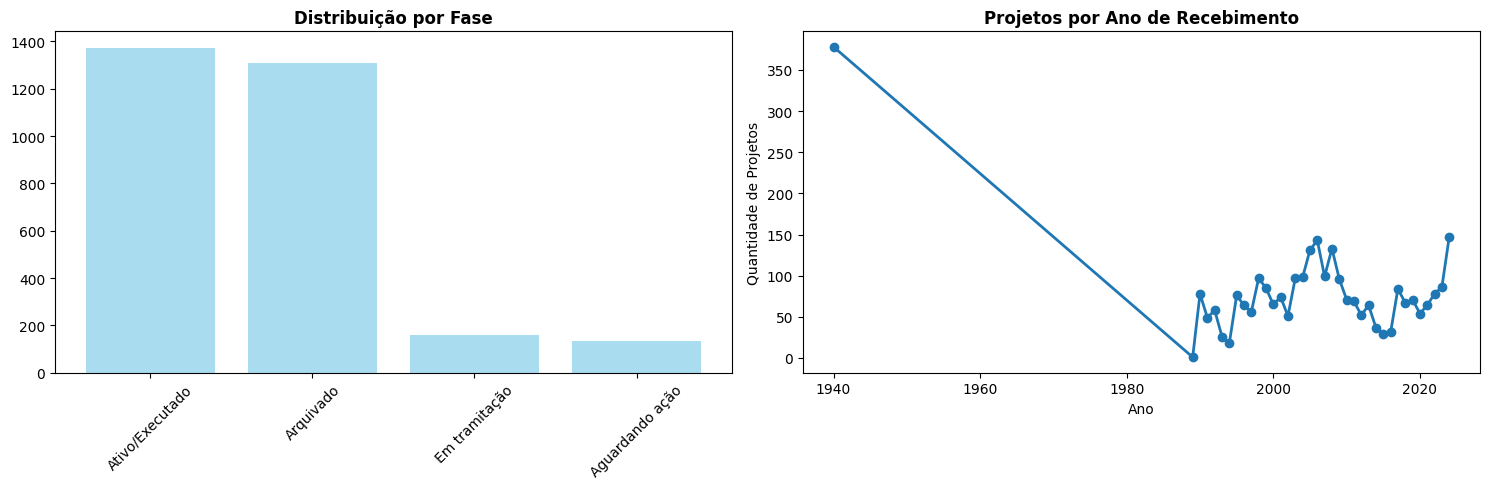

In [49]:
# Apenas gráficos essenciais para validação
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Distribuição por fase
fase_counts = df_final['fase_tipo'].value_counts()
axes[0].bar(fase_counts.index, fase_counts.values, color='skyblue', alpha=0.7)
axes[0].set_title('Distribuição por Fase', fontweight='bold')
axes[0].tick_params(axis='x', rotation=45)


# Projetos por ano
ano_counts = df_final['ano_recebimento'].value_counts().sort_index()
axes[1].plot(ano_counts.index, ano_counts.values, marker='o', linewidth=2)
axes[1].set_title('Projetos por Ano de Recebimento', fontweight='bold')
axes[1].set_xlabel('Ano')
axes[1].set_ylabel('Quantidade de Projetos')

plt.tight_layout()
plt.show()

## 6. Exportação para Locker Studio

In [50]:
# Limpeza final das strings
print("🧹 LIMPEZA FINAL DAS STRINGS...")
for col in df_final.select_dtypes(include='object').columns:
    df_final.loc[:, col] = df_final[col].str.strip()

🧹 LIMPEZA FINAL DAS STRINGS...


In [52]:
# Exportar dataset final
caminho_export = '/content/drive/MyDrive/Projeto EBAC FINAL/dados_final.csv'
df_final.to_csv(caminho_export, index=False, sep=';', decimal=',')

print(f"✅ DATASET EXPORTADO COM SUCESSO!")
print(f"📁 Local: {caminho_export}")
print(f"📊 Dimensões finais: {df_final.shape[0]:,} linhas × {df_final.shape[1]} colunas")
print(f"💾 Tamanho aproximado: {df_final.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")

✅ DATASET EXPORTADO COM SUCESSO!
📁 Local: /content/drive/MyDrive/Projeto EBAC FINAL/dados_final.csv
📊 Dimensões finais: 2,977 linhas × 23 colunas
💾 Tamanho aproximado: 1.71 MB


In [53]:
# Finalização
print("🎉 PREPARAÇÃO DE DADOS CONCLUÍDA!")
print(f"⏰ Timestamp: {pd.Timestamp.now().strftime('%d/%m/%Y %H:%M:%S')}")
print("📊 O dataset está pronto para ser usado no Locker Studio")

🎉 PREPARAÇÃO DE DADOS CONCLUÍDA!
⏰ Timestamp: 15/11/2025 23:49:31
📊 O dataset está pronto para ser usado no Locker Studio


# 7. 📊 Relatório Interativo no Locker Studio

## Todo o processamento realizado neste notebook foi utilizado para alimentar um **relatório interativo completo** no Locker Studio com:
## **📈 Principais Visualizações:**
    - KPIs de desempenho geral
    - Distribuição por região e setor
    - Performance por fonte de financiamento
    - Métricas de eficiência operacional

# **🔍 Funcionalidades Interativas:**
    - Filtros dinâmicos por período, região e fase
    - Drill-down para detalhamento
    - Comparativos temporais
    - Análise de portfólio

# 📊 **[Clique aqui para acessar o Dashboard Interativo](https://lookerstudio.google.com/reporting/b5e212b4-9d2b-44c1-90cf-665ba42feb4a)**